In [40]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

In [41]:
# Load data
encoded = pd.read_csv('modeling_data.csv')

In [42]:
# Features to select with correlation
features = ['Z_SCORE', 'AUC', 'PATHWAY_NAME', 'TARGET', 'DRUG_NAME', 'GDSC Tissue descriptor 1',
            'GDSC Tissue descriptor 2', 'CANCER_TYPE', 'TCGA_DESC', 'Growth Properties_Adherent']

# Load features and target
X = encoded[features]
y = encoded['LN_IC50']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
# RandomForest
# Initiate model
rf_model = RandomForestRegressor(n_estimators=100,  # number of trees
                                 max_depth=None,    # expand until all leaves are pure
                                 random_state=42,
                                 n_jobs=-1)         # use all processors

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

print(f"Random Forest R² score: {r2:.4f}")
print(f"Random Forest RMSE: {rmse:.4f}")
print(f"CV R² mean: {cv_scores.mean():.4f} | std: {cv_scores.std():.4f}")


Random Forest R² score: 0.9969
Random Forest RMSE: 0.1545
CV R² mean: 0.9484 | std: 0.0310


High R squared score: predictions are close to actual values, but should be caution of overfitting

Low RMSE score: small error from the target 

CV R squared mean: high variance on unseen data and standarad deviation is low --> generalize well

overall: Generalize well, overall not overfitting much

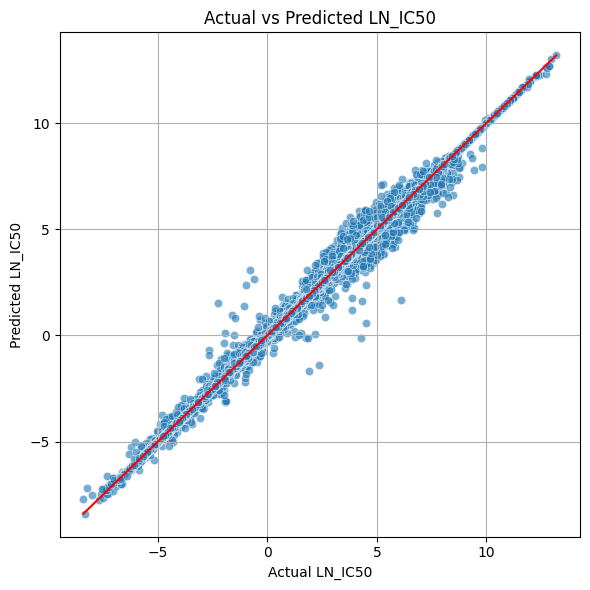

In [44]:
# Check with actual vs predicted plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xlabel("Actual LN_IC50")
plt.ylabel("Predicted LN_IC50")
plt.title("Actual vs Predicted LN_IC50")
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
# Check with simpler model: linear regression
# Initialize and fit the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred = lr_model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression R² score: {r2:.4f}")
print(f"Linear Regression RMSE: {rmse:.4f}")

Linear Regression R² score: 0.9779
Linear Regression RMSE: 0.4119


Simpler model shows similar results!

Overall model good prediction.

In [46]:
# Try with deep learning with pytorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Convert data to tensors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_array = y.values.reshape(-1, 1)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_array, dtype=torch.float32)

# Split into train/test tensors
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train) # Pairs multiple tensors into dataset; for dataloading
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # datasets into mini batches for ease of run
test_loader = DataLoader(test_dataset, batch_size=64)

# Define a simple neural network
class SimpleRegressor(nn.Module):
    def __init__(self, input_dim):
        super(SimpleRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Initialize model, loss, optimizer
model = SimpleRegressor(X_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    preds = model(X_test).numpy()
    y_true = y_test.numpy()

r2 = r2_score(y_true, preds)
mse = mean_squared_error(y_true, preds)
rmse = np.sqrt(mse)

print(f"PyTorch R² score: {r2:.4f}")
print(f"PyTorch RMSE: {rmse:.4f}")


Epoch [10/100], Loss: 0.0777
Epoch [20/100], Loss: 0.0516
Epoch [30/100], Loss: 0.0435
Epoch [40/100], Loss: 0.0909
Epoch [50/100], Loss: 0.0286
Epoch [60/100], Loss: 0.0324
Epoch [70/100], Loss: 0.0599
Epoch [80/100], Loss: 0.0297
Epoch [90/100], Loss: 0.0439
Epoch [100/100], Loss: 0.0725
PyTorch R² score: 0.9936
PyTorch RMSE: 0.2214
